# K-means Clustering for Fruit Classification
# 
### This notebook demonstrates unsupervised clustering of fruit images (Apple, Cherry, Tomato) using K-means with UMAP dimensionality reduction.

### 1. Import Required Libraries

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, adjusted_rand_score, normalized_mutual_info_score, confusion_matrix
from scipy.stats import mode
import warnings
import umap
import matplotlib.pyplot as plt
import seaborn as sns

warnings.filterwarnings("ignore", category=FutureWarning)

/home/mohamed/Desktop/FCAI/ML/project/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### 2. Load and Merge Training and Test Datasets

In [2]:
print("Loading datasets...")
train_df = pd.read_csv("../Dataset/train_processed.csv")
test_df  = pd.read_csv("../Dataset/test_processed.csv")
print("Datasets loaded.")

# Merge train and test into one dataset for clustering
merged_df = pd.concat([train_df, test_df], axis=0, ignore_index=True)

print(f"\nTrain samples: {len(train_df)}")
print(f"Test samples: {len(test_df)}")
print(f"Total merged samples: {len(merged_df)}")

Loading datasets...
Datasets loaded.

Train samples: 34800
Test samples: 12233
Total merged samples: 47033


### 3. Extract Features and Labels

In [3]:
# Extract labels and features from merged dataset
true_labels = merged_df["label"].values
features_df = merged_df.drop("label", axis=1)

numeric_columns = features_df.columns

print(f"Number of features: {len(numeric_columns)}")
print(f"Feature shape: {features_df.shape}")
print(f"\nClass distribution:")
print(pd.Series(true_labels).value_counts().sort_index())

Number of features: 1764
Feature shape: (47033, 1764)

Class distribution:
0    21131
1    12230
2    13672
Name: count, dtype: int64


### 4. Build K-means Pipeline with Preprocessing and UMAP

In [ ]:
# Create preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('scaler', StandardScaler(), numeric_columns)
    ]
)

# Build complete pipeline: Scaling -> UMAP -> K-means
kmeans_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('umap', umap.UMAP(
        n_components=50,          
        n_neighbors=15,             
        min_dist=0.1,               
        metric='euclidean',
        random_state=42
    )),
    ('kmeans', KMeans(
        n_clusters=20,              
        random_state=42, 
        n_init=20,                  
        max_iter=500,               
        algorithm='lloyd'
    ))
])

print("Pipeline created successfully!")

Pipeline created successfully!


### 5. Train K-means on Merged Dataset

In [5]:
print("Training K-means pipeline on merged dataset...")
kmeans_pipeline.fit(features_df)

print("Training complete!")

Training K-means pipeline on merged dataset...
This may take a few minutes...



/home/mohamed/Desktop/FCAI/ML/project/.venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Training complete!


### 6. Make Predictions and Evaluate

In [8]:
# Map cluster labels to predicted class labels
predicted_labels = np.array([label_mapping[c] for c in cluster_labels])

# Calculate evaluation metrics
ari = adjusted_rand_score(true_labels, cluster_labels)
nmi = normalized_mutual_info_score(true_labels, cluster_labels)
accuracy = accuracy_score(true_labels, predicted_labels)

print("\n========= FINAL RESULTS (Merged Dataset) =========")
print(f"Accuracy (after mapping): {accuracy*100:.2f}%")
print(f"ARI (Adjusted Rand Index): {ari:.4f}")
print(f"NMI (Normalized Mutual Info): {nmi:.4f}")


========= FINAL RESULTS (Merged Dataset) =========
Accuracy (after mapping): 61.13%
ARI (Adjusted Rand Index): 0.0291
NMI (Normalized Mutual Info): 0.1782


### 7. Display Confusion Matrix

In [9]:
cm = confusion_matrix(true_labels, predicted_labels)

print("\n=== Confusion Matrix ===")
print(cm)

# Per-class accuracy
print("\n=== Per-Class Accuracy ===")
class_names = ["Apple", "Cherry", "Tomato"]
for i in range(len(cm)):
    class_acc = cm[i, i] / cm[i].sum() * 100 if cm[i].sum() > 0 else 0
    print(f"Class {i} ({class_names[i]:6s}): {class_acc:.2f}%")

# Overall statistics
print("\n=== Overall Statistics ===")
print(f"Total samples: {len(true_labels)}")
print(f"Correctly classified: {np.sum(predicted_labels == true_labels)}")
print(f"Misclassified: {np.sum(predicted_labels != true_labels)}")


=== Confusion Matrix ===
[[16604   328  4199]
 [ 5029  2497  4704]
 [ 3712   308  9652]]

=== Per-Class Accuracy ===
Class 0 (Apple ): 78.58%
Class 1 (Cherry): 20.42%
Class 2 (Tomato): 70.60%

=== Overall Statistics ===
Total samples: 47033
Correctly classified: 28753
Misclassified: 18280


### 10. Visualize Confusion Matrix as Heatmap

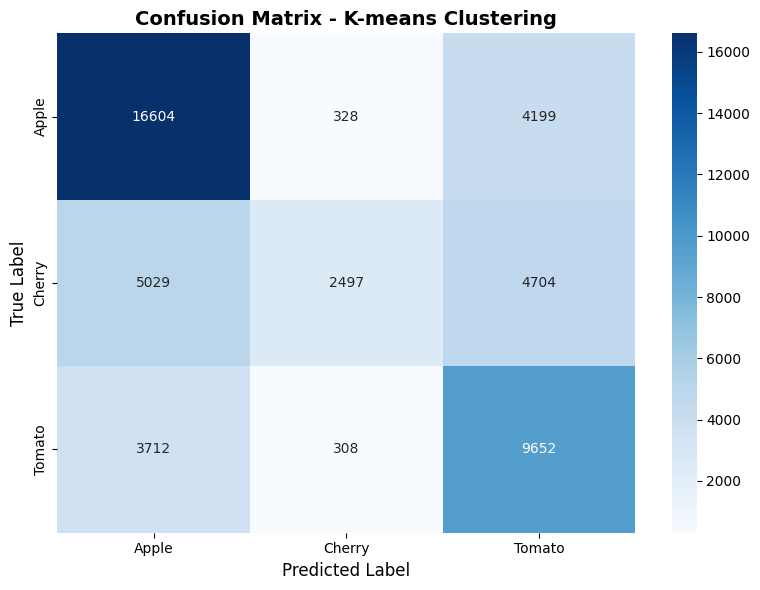

In [10]:
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix - K-means Clustering', fontsize=14, fontweight='bold')
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.tight_layout()
plt.show()